# Importieren von Bibliotheken und Konfigurationen

In [237]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cmasher as cmr # for color maps
from datetime import datetime, timedelta

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [238]:

with open('../models/config.json', 'r') as f:
    config = json.load(f)

postprocess = config['postprocessing']


In [239]:
# Output path
OUTPUT_PATH = postprocess['output_path']

# Input path
INPUT_PATH_S = postprocess['input_path_s']
INPUT_PATH_D = postprocess['input_path_d']


# Funktionendefinition

In [240]:
def calculate_end_date(start_date, period):
    """
    Berechnet das Enddatum basierend auf dem Startdatum und der Periode.

    Parameters:
    - start_date: Startdatum im Format YYYYMMDD (int oder str)
    - period: Periode als Integer (0: Tag, 1: Woche, 2: Monat)

    Returns:
    - end_date: Enddatum im Format YYYYMMDD (int)
    """
    if isinstance(start_date, int):
        start_date = str(start_date)
    start_datetime = datetime.strptime(start_date, '%Y%m%d')
    
    if period == 0:  # Tag
        end_datetime = start_datetime
    elif period == 1:  # Woche
        end_datetime = start_datetime + timedelta(days=6)
    elif period == 2:  # Monat
        # Ende des Monats berechnen
        next_month = start_datetime.replace(day=28) + timedelta(days=4)  # garantiert im nächsten Monat
        end_datetime = next_month - timedelta(days=next_month.day)
    else:
        raise ValueError("Ungültige Periode. Wählen Sie 0: Tag, 1: Woche, 2: Monat.")
    
    return int(end_datetime.strftime('%Y%m%d'))


In [241]:
def load_deterministic_data(input_path, start_date, period_str, period):
    """
    Lädt die deterministischen Daten, behält den ursprünglichen 't'-Index bei und fügt eine 'timestamp'-Spalte hinzu.
    
    Parameters:
    - input_path: Pfad zu den deterministischen CSV-Dateien
    - start_date: Startdatum im Format YYYYMMDD (int oder str)
    - period_str: Periode als String ('day', 'week', 'month')
    - period: Periode als Integer (0: Tag, 1: Woche, 2: Monat)
    
    Returns:
    - df: DataFrame mit ursprünglichem 't'-Index und 'timestamp'-Spalte
    """
    end_date = calculate_end_date(start_date, period)
    #filename = f'd_{start_date}_to_{end_date}_{period_str}_ts.csv'
    filename = f'd_weighted_{start_date}_to_{end_date}_{period_str}_ts.csv'
    file_path = os.path.join(input_path, filename)
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Spaltennamen bereinigen
        df.columns = df.columns.str.strip().str.replace(' ', '')
        
        # Überprüfen, ob 't' in den Spalten ist
        if 't' in df.columns:
            df.set_index('t', inplace=True)
        else:
            print(f"'t' Spalte nicht in {filename} gefunden.")
            return pd.DataFrame()
        
        # Berechnung des Startdatums
        start_datetime = datetime.strptime(str(start_date), '%Y%m%d')
        
        # Überprüfen des minimalen 't'-Werts
        min_t = df.index.min()
        if min_t == 1:
            # 't' beginnt bei 1, daher 1 subtrahieren
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index - 1, unit='h')
        else:
            # 't' beginnt bei 0 oder einem anderen Wert
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index, unit='h')
        
        # Überprüfen der Anzahl der Zeilen
        expected_rows = 24 if period == 0 else 168 if period == 1 else 720  # Für Monat kann angepasst werden
        if period == 2:
            # Für Monat die tatsächliche Anzahl der Tage * 24 berechnen
            end_datetime = datetime.strptime(str(end_date), '%Y%m%d')
            delta = end_datetime - start_datetime
            expected_rows = (delta.days + 1) * 24  # +1 für inklusive Enddatum
        if len(df) != expected_rows:
            print(f"Warnung: Die Anzahl der Zeilen in {filename} ({len(df)}) stimmt nicht mit der erwarteten Anzahl ({expected_rows}) überein.")
        
        return df
    else:
        print(f"Deterministische Datei {filename} nicht im Pfad {input_path} gefunden.")
        return pd.DataFrame()


In [242]:
def load_stochastic_data(input_path, start_date, period_str, period):
    """
    Lädt die stochastischen Daten, sortiert die Szenarien numerisch, behält den ursprünglichen 't'-Index bei und fügt eine einzige 'timestamp'-Spalte hinzu.
    
    Parameters:
    - input_path: Pfad zu den stochastischen CSV-Dateien
    - start_date: Startdatum im Format YYYYMMDD (int oder str)
    - period_str: Periode als String ('day', 'week', 'month')
    - period: Periode als Integer (0: Tag, 1: Woche, 2: Monat)
    
    Returns:
    - combined_df: Kombinierter DataFrame mit ursprünglichem 't'-Index, einer 'timestamp'-Spalte und sortierten Szenarien
    """
    end_date = calculate_end_date(start_date, period)
    # Regex-Muster zum Extrahieren der Dateiinformationen
    #pattern = re.compile(r's_(.*?)_' + str(start_date) + r'_to_' + str(end_date) + r'_' + re.escape(period_str) + r'_ts\.csv')
    pattern = re.compile(r's_weighted_' + str(start_date) + r'_to_' + str(end_date) + r'_' + re.escape(period_str) + r'_Scenario(\d+)_ts\.csv')
    stochastic_files = []
    
    # Durchsuchen des Verzeichnisses nach passenden Dateien
    for f in os.listdir(input_path):
        if f.startswith('s_') and f.endswith('_ts.csv'):
            match = pattern.match(f)
            if match:
                scenario = match.group(1)
                stochastic_files.append((f, scenario))

    if not stochastic_files:
        print("Keine passenden stochastischen Dateien gefunden.")
        return pd.DataFrame()

    # Sortieren der stochastic_files nach Szenariennummer
    def extract_scenario_number(scenario):
        # Extrahiert die erste gefundene Zahl aus dem Szenarionamen
        numbers = re.findall(r'\d+', scenario)
        return int(numbers[0]) if numbers else float('inf')

    stochastic_files_sorted = sorted(stochastic_files, key=lambda x: extract_scenario_number(x[1]))

    print(stochastic_files)

    # Berechnung der erwarteten Anzahl der Stunden
    start_datetime = datetime.strptime(str(start_date), '%Y%m%d')
    end_datetime_obj = datetime.strptime(str(end_date), '%Y%m%d') + timedelta(hours=23)
    delta = end_datetime_obj - start_datetime
    total_hours = (delta.days + 1) * 24  # +1 für inklusive Enddatum

    # Initialisieren des kombinierten DataFrames und der 'timestamp'-Spalte
    combined_df = pd.DataFrame()
    timestamp_added = False  # Flag, um 'timestamp' nur einmal hinzuzufügen

    # Laden und Kombinieren der stochastischen Daten in der sortierten Reihenfolge
    for filename, scenario in stochastic_files_sorted:
        file_path = os.path.join(input_path, filename)
        df = pd.read_csv(file_path)
        # Spaltennamen bereinigen
        df.columns = df.columns.str.strip().str.replace(' ', '')
        
        # Überprüfen, ob 't' in den Spalten ist
        if 't' in df.columns:
            df.set_index('t', inplace=True)
        else:
            print(f"'t' Spalte nicht in {filename} gefunden.")
            continue
        
        # Überprüfen der Anzahl der Zeilen
        if len(df) != total_hours:
            print(f"Die Anzahl der Zeilen in {filename} ({len(df)}) stimmt nicht mit der erwarteten Anzahl ({total_hours}) überein.")
            continue
        
        # Überprüfen des minimalen 't'-Werts
        min_t = df.index.min()
        if min_t == 1:
            # 't' beginnt bei 1, daher 1 subtrahieren
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index - 1, unit='h')
        else:
            # 't' beginnt bei 0 oder einem anderen Wert
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index, unit='h')
        
        if not timestamp_added:
            # Füge die 'timestamp'-Spalte nur einmal hinzu
            combined_df['timestamp'] = df['timestamp']
            timestamp_added = True
        else:
            # Entferne die 'timestamp'-Spalte für nachfolgende Szenarien
            df.drop(columns=['timestamp'], inplace=True)
        
        # Hinzufügen des Szenarionamens als Präfix zu den Spalten (außer 'timestamp')
        data_columns = df.columns.tolist()
        if 'timestamp' in data_columns:
            data_columns.remove('timestamp')
    
        
        # Kombinieren der Daten
        combined_df = pd.concat([combined_df, df], axis=1)
    
    return combined_df




In [243]:
# Create DataFrames
period_dict = {0: 'day', 1: 'week', 2: 'month'}

# Deterministic data Period: day
START_DATE = 20230303
PERIOD = 0
PERIOD_STR = period_dict[PERIOD]
df_deterministic_day = load_deterministic_data(INPUT_PATH_D, START_DATE, PERIOD_STR, PERIOD)

# Deterministic data Period: week
# START_DATE = 20230327
# PERIOD = 1
# PERIOD_STR = period_dict[PERIOD]
# df_deterministic_week = load_deterministic_data(INPUT_PATH_D, START_DATE, PERIOD_STR, PERIOD)


###################################################################################################

# Stochastic data Period: day
START_DATE = 20230303
PERIOD = 0
PERIOD_STR = period_dict[PERIOD]
df_stochastic_day = load_stochastic_data(INPUT_PATH_S, START_DATE, PERIOD_STR, PERIOD)

#Stochastic data Period: week
# START_DATE = 20230327
# PERIOD = 1
# PERIOD_STR = period_dict[PERIOD]
# df_stochastic_week = load_stochastic_data(INPUT_PATH_S, START_DATE, PERIOD_STR, PERIOD)

[('s_weighted_20230303_to_20230303_day_Scenario10_ts.csv', '10'), ('s_weighted_20230303_to_20230303_day_Scenario1_ts.csv', '1'), ('s_weighted_20230303_to_20230303_day_Scenario2_ts.csv', '2'), ('s_weighted_20230303_to_20230303_day_Scenario3_ts.csv', '3'), ('s_weighted_20230303_to_20230303_day_Scenario4_ts.csv', '4'), ('s_weighted_20230303_to_20230303_day_Scenario5_ts.csv', '5'), ('s_weighted_20230303_to_20230303_day_Scenario6_ts.csv', '6'), ('s_weighted_20230303_to_20230303_day_Scenario7_ts.csv', '7'), ('s_weighted_20230303_to_20230303_day_Scenario8_ts.csv', '8'), ('s_weighted_20230303_to_20230303_day_Scenario9_ts.csv', '9')]


In [244]:
df_stochastic_day.to_csv('stochastic_day.csv')
df_deterministic_day.to_csv('deterministic_day.csv')

In [245]:
# Szenarien
scenarios = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']

# Generate colors using cmasher colormap for scenarios
color_mapping = {}
num_scenarios = len(scenarios)
scenario_colors = cmr.take_cmap_colors('cmr.chroma', N=num_scenarios, cmap_range=(0.3, 0.9))

# Assign colors to scenarios (using cmasher)
for i, scenario in enumerate(scenarios):
    color_mapping[scenario] = scenario_colors[i]

# Fixed color for global parameters
color_mapping['HEAT_PRICE'] = 'red'
color_mapping['GAS_PRICE'] = 'orange'
color_mapping['POWER_PRICE'] = 'blue'


# Font sizes
fontsize_title = 18
fontsize_label = 16
fontsize_ticks = 16
fontsize_legend = 14


In [246]:
# Für Data z.B aus meinen Asset .csv Datein
def get_data(filepath, index_col=0):
    """
    Liest eine CSV-Datei ein und gibt das resultierende DataFrame zurück.

    Parameters:
    - filepath (str): Der Pfad zur CSV-Datei.
    - index_col (int oder str, optional): Die Spalte, die als Index verwendet werden soll. Standard ist 0.

    Returns:
    - pd.DataFrame: Das eingelesene DataFrame.
    """
    data = pd.read_csv(filepath, index_col=index_col)
    return data

In [247]:
# df_deterministic_day.head()
# df_deterministic_week.head()
# df_stochastic_day.head()
# df_stochastic_week.head()

In [248]:
def plot_heat_demand_scenarios(df, scenarios_to_plot, title, x_label, y_label, 
                               xtick_step=24, plot_planned_heat_demand=True):
    """
    Plottet Heat Demand Szenarien aus dem gegebenen DataFrame und optional die geplante Wärmeanforderung.
    
    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten
    - scenarios_to_plot (list of str): Liste der Szenarien, die geplottet werden sollen
    - title (str): Titel des Plots
    - x_label (str): Bezeichnung der x-Achse
    - y_label (str): Bezeichnung der y-Achse
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks (Standard: 24)
    - plot_planned_heat_demand (bool): Ob die geplante Wärmeanforderung geplottet werden soll (Standard: True)
    """
    data_to_plot = []
    labels = []
    max_heat_demand = 0  # Variable zum Speichern des maximalen Wärmeanforderungswerts
    
    for scenario in scenarios_to_plot:
        scenario_scenario_column = f'{scenario}.heat_demand_scenario'
        scenario_planned_column = f'{scenario}.heat_demand'
        
        if scenario_scenario_column in df.columns:
            data_to_plot.append((df.index, df[scenario_scenario_column], scenario))
            labels.append(scenario)
            max_heat_demand = max(max_heat_demand, df[scenario_scenario_column].max())  # Maximalen Wert aktualisieren
        else:
            print(f"Spalte {scenario_scenario_column} existiert nicht im DataFrame.")

    # Get corresponding colors directly from the color mapping (fixed for each scenario)
    plot_colors = [color_mapping.get(scenario, 'black') for scenario in scenarios_to_plot]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
    
    # Plot the scenarios (background)
    for i, (index, data, scenario) in enumerate(data_to_plot):
        ax.plot(index, data, label=f'{scenario}', color=plot_colors[i], 
                linewidth=1, alpha=0.6)
    
    # Plot the planned heat demand (foreground) if enabled
    if plot_planned_heat_demand:
        # Annahme: Die geplante Wärmeanforderung ist für alle Szenarien gleich, also wähle das erste Szenario
        first_scenario = scenarios_to_plot[0]
        planned_column = f'{first_scenario}.heat_demand'
        
        if planned_column in df.columns:
            ax.plot(df.index, df[planned_column], 
                    label='planned heat demand', 
                    color=color_mapping.get('HEAT_PRICE', 'red'), 
                    linewidth=2.5)
            max_heat_demand = max(max_heat_demand, df[planned_column].max())  # Maximalen Wert aktualisieren
        else:
            print(f"Spalte {planned_column} existiert nicht im DataFrame.")
    
    # Horizontale Linie bei y=0 hinzufügen
    ax.axhline(0, color='black', linewidth=1)
    
    # Achsenbeschriftungen und Titel setzen
    ax.set_title(title, fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # X-Achsen-Ticks setzen
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)
    
    # X-Achsen-Grenzen setzen
    ax.set_xlim([0, len(df)+1])
    
    # Y-Achsen-Grenzen setzen, basierend auf dem maximalen Wert der geplotteten Wärmeanforderungen
    ax.set_ylim([0, max_heat_demand + 50])
    
    # Tick-Parameter setzen
    ax.tick_params(axis='both', labelsize=fontsize_ticks)
    
    # Legende hinzufügen und doppelte Labels entfernen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=4, fontsize=fontsize_legend)
    
    # Layout anpassen
    plt.tight_layout()
    
    # Plot anzeigen
    plt.show()


In [249]:
def plot_prices(df, title, x_label, y_label, xtick_step):
    """
    Plottet die Preise für Gas, Strom und Wärme über die Zeit.

    Parameters:
    - df: DataFrame, das die Preisdaten enthält.
    - start_date: Startdatum für den Plot (Index oder Datetime).
    - end_date: Enddatum für den Plot (Index oder Datetime).
    - title: Titel des Plots.
    """
    # Überprüfen, ob die notwendigen Spalten vorhanden sind
    required_columns = ['GAS_PRICE', 'POWER_PRICE', 'HEAT_PRICE']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Die folgenden benötigten Spalten fehlen im DataFrame: {missing_columns}")
        return

    # Daten für den angegebenen Zeitraum extrahieren
    df_plot = df.loc[:,required_columns]

    # Index für die x-Achse
    x_values = df_plot.index

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Plotten der Preise
    ax.plot(x_values, df_plot['GAS_PRICE'], label='gas', color=color_mapping['GAS_PRICE'])
    ax.plot(x_values, df_plot['POWER_PRICE'], label='power', color=color_mapping['POWER_PRICE'])
    ax.plot(x_values, df_plot['HEAT_PRICE'], label='heat', color=color_mapping['HEAT_PRICE'])

    ax.set_title(title, fontsize=fontsize_title)
    ax.grid()
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.legend(loc='upper center', fontsize=fontsize_legend, bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)
    ax.set_xlim([0, len(df)+1])
    ax.tick_params(axis='both', labelsize=fontsize_ticks)
   

    # Layout anpassen und Plot anzeigen
    plt.tight_layout()
    plt.show()

In [250]:
def plot_component_stacking(df, title, x_label, y_label, xtick_step=4):
    """
    Erstellt einen Komponenten-Stacking-Plot für die gegebenen Daten.

    Parameters:
    - df: DataFrame mit den Daten
    - title: Titel des Plots
    - x_label: Bezeichnung der x-Achse
    - y_label: Bezeichnung der y-Achse
    - xtick_step: Schrittweite für die x-Achsen-Ticks (Standard: 24)
    """
    # Extrahiere die Daten
    hours = df.index
    chp1 = df['chp1.heat']
    chp2 = df['chp2.heat']
    boiler = df['boiler1.heat']
    storage_in = -df['heat_storage1.heat_charge']  # Negative for charging operations
    storage_out = df['heat_storage1.heat_discharge']  # Positive for discharging
    storage = storage_in + storage_out  # Net storage flow
    hd = df['heat_demand']  # Heat demand (line plot)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Initialize cumulative sums for stacking
    pos_bottom = np.zeros(len(hours))
    neg_bottom = np.zeros(len(hours))

    # Components to plot
    components = [
        (chp1, 'CHP_1', 'green'),
        (chp2, 'CHP_2', 'darkgreen'),
        (boiler, 'Boiler', 'blue'),
        (storage, 'Storage', 'grey'),
    ]

    # To avoid duplicate labels in the legend
    handles = []
    labels = []

    # Plot each component
    for data_component, label, color in components:
        data_component = np.array(data_component)
        # Separate positive and negative values
        pos_values = np.where(data_component > 0, data_component, 0)
        neg_values = np.where(data_component < 0, data_component, 0)
        # Plot positive values
        if np.any(pos_values):
            bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
            pos_bottom += pos_values
            # Only add label if not already added
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)
        # Plot negative values
        if np.any(neg_values):
            bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
            neg_bottom += neg_values
            # Only add label if not already added
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)

    # Plot the line for Heat Demand
    line_hd, = ax.plot(hours, hd, label='Heat Demand', color='red', linestyle='--', linewidth=2)
    handles.append(line_hd)
    labels.append('Heat Demand')

    # Add horizontal line at y=0
    ax.axhline(0, color='black', linewidth=1)
    
    ax.set_title(title, fontsize=fontsize_title)
   

    # Adjust the grid, ticks, and axis limits
    ax.grid(True)
    ax.set_xticks(np.arange(0, 25, xtick_step))  # X-axis with hours
    ax.set_xlim([0, 25])  # Set the X range
    ax.set_ylim([neg_bottom.min() - 50, pos_bottom.max() + 50])  # Adjust Y range based on data
    ax.tick_params(axis='both', labelsize=fontsize_ticks)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)

    # Add the legend
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=4, fontsize=fontsize_legend)

    # Show the plot
    plt.tight_layout()
    plt.show() 

In [251]:
def plot_commitment_decision(df, scenario_to_plot, title, x_label, y_label, xtick_step):
    """
    Erstellt einen Plot für die Commitment-Entscheidung.

    Parameters:
    - df: DataFrame mit den Daten
    - title: Titel des Plots
    - x_label: Bezeichnung der x-Achse
    - y_label: Bezeichnung der y-Achse
    - xtick_step: Schrittweite für die x-Achsen-Ticks (Standard: 24)
    """
    # Extrahiere die Daten
    hours = df.index
    chp1_commitment = df[f'{scenario_to_plot}.chp1.heat']
    chp2_commitment = df[f'{scenario_to_plot}.chp2.heat']
    boiler_commitment = df[f'{scenario_to_plot}.boiler1.heat']
    storage_commitment_charge = -df[f'{scenario_to_plot}.heat_storage1.heat_charge'] 
    storage_commitment_discharge = df[f'{scenario_to_plot}.heat_storage1.heat_discharge']
    storage_commitment = storage_commitment_charge + storage_commitment_discharge
    planned_hd = df[f'{scenario_to_plot}.heat_demand']
    actual_hd = df[f'{scenario_to_plot}.heat_demand_scenario']

    components = [
        (chp1_commitment, 'CHP_1', 'green'),
        (chp2_commitment, 'CHP_2', 'darkgreen'),
        (boiler_commitment, 'Boiler', 'blue'),
        (storage_commitment, 'Storage', 'grey'),
    ]

    # Erstelle die Figur und Achse
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Initialisiere die unteren Grenzen für die Balkenstapel
    pos_bottom = np.zeros(len(df))
    neg_bottom = np.zeros(len(df))

    handles = []
    labels = []

    # Plot jede Komponente
    for data_component, label, color in components:
        data_component = np.array(data_component)
        # Trenne positive und negative Werte
        pos_values = np.where(data_component > 0, data_component, 0)
        neg_values = np.where(data_component < 0, data_component, 0)
        # Plot positive Werte
        if np.any(pos_values):
            bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5, label=label if label not in labels else "")
            pos_bottom += pos_values
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)
        # Plot negative Werte
        if np.any(neg_values):
            bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5, label=label if label not in labels else "")
            neg_bottom += neg_values
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)

    # Plot geplante und tatsächliche Wärmeanforderung
    line_planned, = ax.plot(hours, planned_hd, label='planned heat demand', color='red',  linestyle='--' )
    line_actual, = ax.plot(hours, actual_hd, label='actual heat demand', color='red', marker='o')
    handles.extend([line_planned, line_actual])
    labels.extend(['planned heat demand', 'actual heat demand'])

    # Horizontale Linie bei y=0 hinzufügen
    ax.axhline(0, color='black', linewidth=1)

    # Achsenbeschriftungen und Titel setzen
    ax.set_title(f'{title} - {scenario_to_plot}', fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize= fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True)
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)
    ax.set_xlim([0, len(df)+1])
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Legende hinzufügen
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=3, fontsize=fontsize_legend)

    # Layout anpassen und Plot anzeigen
    plt.tight_layout()
    plt.show()

In [252]:
def plot_dispatch(df, scenario_to_plot, title, x_label, y_label, xtick_step=24):
    """
    Erstellt einen Plot für geplante und tatsächliche Wärmeanforderung sowie den Dispatch als Balken.

    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten
    - scenario_to_plot (str): Das Szenario, das geplottet werden soll (z.B. 'Scenario1')
    - title (str): Titel des Plots
    - x_label (str): Bezeichnung der x-Achse
    - y_label (str): Bezeichnung der y-Achse
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks (Standard: 24)
    """
    # Überprüfen, ob die notwendigen Spalten vorhanden sind
    required_columns = [
        f'{scenario_to_plot}.heat_demand',
        f'{scenario_to_plot}.heat_demand_scenario'
    ]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Die folgenden benötigten Spalten fehlen im DataFrame: {missing_columns}")
        return

    # Extrahiere die Daten
    hours = df.index
    planned_hd = df[f'{scenario_to_plot}.heat_demand']
    actual_hd = df[f'{scenario_to_plot}.heat_demand_scenario']
    dispatch = actual_hd - planned_hd

    # Prüfen auf NaN-Werte und ggf. auffüllen oder interpolieren
    if planned_hd.isnull().any() or actual_hd.isnull().any():
        print("Warnung: NaN-Werte in geplanten oder tatsächlichen Wärmeanforderungen gefunden. Diese werden durch Interpolation ersetzt.")
        planned_hd = planned_hd.interpolate()
        actual_hd = actual_hd.interpolate()
        dispatch = actual_hd - planned_hd

    # Erstelle die Figur und Achse
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Plot geplante und tatsächliche Wärmeanforderung
    line_planned, = ax.plot(hours, planned_hd, label='planned heat demand', color='red', linestyle='--')
    line_actual, = ax.plot(hours, actual_hd, label='actual heat demand', color='red', marker='o')

    # Plot Dispatch als separate Balken
    # Positive Dispatch (tatsächlich > geplant)
    pos_dispatch = np.where(dispatch > 0, dispatch, 0)
    # Negative Dispatch (tatsächlich < geplant)
    neg_dispatch = np.where(dispatch < 0, dispatch, 0)

    # Balken für positiven Dispatch nach oben
    bars_pos = ax.bar(hours, pos_dispatch, color='orange', alpha=0.8, label='dispatch (actual > planned)')
    # Balken für negativen Dispatch nach unten
    bars_neg = ax.bar(hours, neg_dispatch, color='orange', alpha=0.5, label='dispatch (actual < planned)')

    # Horizontale Linie bei y=0 hinzufügen
    ax.axhline(0, color='black', linewidth=1)

    # Achsenbeschriftungen und Titel setzen
    ax.set_title(f'{title} - {scenario_to_plot}', fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True)

    # X-Achsen-Ticks setzen
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)

    # X-Achsen-Grenzen setzen
    ax.set_xlim([0, len(df)+1])

    # Tick-Parameter setzen
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Legende hinzufügen und doppelte Labels entfernen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=2, fontsize=fontsize_legend)

    # Layout anpassen und Plot anzeigen
    plt.tight_layout()
    plt.show()

In [253]:
def plot_component_stacking_stochastic(df, 
                                       scenarios_to_plot, 
                                       title, 
                                       x_label, 
                                       y_label, 
                                       xtick_step,
                                       soc_plot=False):
    """
    Plottet den State of Charge (SoC) des Speichers über die Zeit für gegebene Szenarien.
    
    Parameters:
    - df (pd.DataFrame): DataFrame mit stochastischen Daten.
    - scenarios_to_plot (list of str): Liste der Szenarien, die geplottet werden sollen.
    - title (str): Titel des Plots.
    - x_label (str): Bezeichnung der x-Achse.
    - y_label (str): Bezeichnung der y-Achse.
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks.
    
    Returns:
    - None: Zeigt den Plot an.
    """
    # Use the index of the DataFrame as time (hours)
    hours = df.index

    # Extract the first-stage data (common across scenarios)
    chp1 = df['Scenario1.chp1.heat']
    chp2 = df['Scenario1.chp2.heat']
    boiler = df['Scenario1.boiler1.heat']
    storage_in = -df['Scenario1.heat_storage1.heat_charge']  # Negative for charging operations
    storage_out = df['Scenario1.heat_storage1.heat_discharge']  # Positive for discharging
    storage = storage_in + storage_out  # Net storage flow
    planned_hd = df['Scenario1.heat_demand']  # Planned heat demand

    # Components for first-stage plot
    first_stage_components = [
        (chp1, 'CHP_1', 'green'),
        (chp2, 'CHP_2', 'darkgreen'),
        (boiler, 'Boiler', 'blue'),
        (storage, 'Storage', 'grey'),
    ]

    # Number of scenarios
    scenarios = scenarios_to_plot

    # Set up the figure with subplots
    fig, axes = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(12, 6 * len(scenarios)), dpi=120)

    # If there's only one scenario, axes might not be an array
    if len(scenarios) == 1:
        axes = [axes]

    for ax, scenario in zip(axes, scenarios):
        # Extract second-stage data for the scenario
        dispatch_charge = -df[f'{scenario}.heat_storage1.dispatch_heat_charge']  # Negative for charging
        dispatch_discharge = df[f'{scenario}.heat_storage1.dispatch_heat_discharge']  # Positive for discharging
        actual_hd = df[f'{scenario}.heat_demand_scenario']  # Actual heat demand for the scenario

        charge = df[f'{scenario}.heat_storage1.heat_charge']
        discharge = df[f'{scenario}.heat_storage1.heat_discharge']
        soc = charge.cumsum() + dispatch_charge.cumsum() - discharge.cumsum() - dispatch_discharge.cumsum()

        # Initialize cumulative sums for stacking
        pos_bottom = np.zeros(len(hours))
        neg_bottom = np.zeros(len(hours))

        # Plot first-stage components
        handles = []
        labels = []
        for data_component, label, color in first_stage_components:
            data_component = np.array(data_component)
            # Separate positive and negative values
            pos_values = np.where(data_component > 0, data_component, 0)
            neg_values = np.where(data_component < 0, data_component, 0)
            # Plot positive values
            if np.any(pos_values):
                bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
                pos_bottom += pos_values
                if label not in labels:
                    handles.append(bars[0])
                    labels.append(label)
            # Plot negative values
            if np.any(neg_values):
                bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
                neg_bottom += neg_values
                if label not in labels:
                    handles.append(bars[0])
                    labels.append(label)

        # Plot second-stage adjustments (dispatch)
        # We'll plot the adjustments as an overlay on top of the first-stage storage component
        dispatch_total = dispatch_charge + dispatch_discharge
        # Separate positive and negative adjustments
        dispatch_pos = np.where(dispatch_total > 0, dispatch_total, 0)
        dispatch_neg = np.where(dispatch_total < 0, dispatch_total, 0)
        # Plot positive adjustments
        if np.any(dispatch_pos):
            bars = ax.bar(hours, dispatch_pos, bottom=pos_bottom, color='orange', label='dispatch adjustment')
            pos_bottom += dispatch_pos
            if 'dispatch adjustment' not in labels:
                handles.append(bars[0])
                labels.append('dispatch adjustment')
        # Plot negative adjustments
        if np.any(dispatch_neg):
            bars = ax.bar(hours, dispatch_neg, bottom=neg_bottom, color='orange')
            neg_bottom += dispatch_neg

        # Plot planned and actual heat demand
        line_planned, = ax.plot(hours, planned_hd, label='planned heat demand', color='red', linestyle='--')
        line_actual, = ax.plot(hours, actual_hd, label='actual heat demand', color='red', marker='o')
        
        if soc_plot==True:
            ax.plot(hours, soc, label='state of charge', color='purple', linestyle='--')
        else:
            pass

        handles.extend([line_planned, line_actual])
        labels.extend(['planned heat demand', 'actual heat demand'])

        # Add horizontal line at y=0
        ax.axhline(0, color='black', linewidth=1)

        # Set axis labels and title
        ax.set_title(f'{title} - {scenario}', fontsize=fontsize_title)
        ax.set_ylabel(y_label, fontsize=fontsize_label)
        ax.set_xlabel(x_label, fontsize=fontsize_label)

        # Adjust the grid, ticks, and axis limits
        ax.grid(True)
        ax.set_xticks(np.arange(0, len(df)+1, xtick_step))  # X-axis with hours
        ax.set_xlim([0, len(df)+1])  # Set the X range
        
        if soc_plot==False:
            y_min = min(neg_bottom.min(), dispatch_neg.min(), -50)
            y_max = max(pos_bottom.max(), dispatch_pos.max(), 50)
        else:
            y_min = min(neg_bottom.min(), soc.min(), -50)
            y_max = max(pos_bottom.max(), soc.max(), 50)
        ax.set_ylim([y_min - 50, y_max + 50])  # Adjust Y range based on data
        ax.tick_params(axis='both', labelsize=fontsize_ticks)

        # Add the legend
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                fancybox=True, shadow=True, ncol=3, fontsize=fontsize_legend)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [254]:
def plot_cumulative_dispatch(df, scenario_to_plot, title, x_label, y_label, xtick_step=24):
    """
    Erstellt einen Plot für die kumulierte Differenz (Dispatch) zwischen tatsächlicher und geplanter Wärmeanforderung als Balken.
    
    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten
    - scenario_to_plot (str): Das Szenario, das geplottet werden soll (z.B. 'Scenario1')
    - title (str): Titel des Plots
    - x_label (str): Bezeichnung der x-Achse
    - y_label (str): Bezeichnung der y-Achse
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks (Standard: 24)
    """
    # Überprüfen, ob die notwendigen Spalten vorhanden sind
    required_columns = [
        f'{scenario_to_plot}.heat_demand',
        f'{scenario_to_plot}.heat_demand_scenario'
    ]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Die folgenden benötigten Spalten fehlen im DataFrame: {missing_columns}")
        return

    # Extrahiere die Daten
    hours = df.index
    planned_hd = df[f'{scenario_to_plot}.heat_demand']
    actual_hd = df[f'{scenario_to_plot}.heat_demand_scenario']
    dispatch = actual_hd - planned_hd
    cumulative_dispatch = dispatch.cumsum()

    # Prüfen auf NaN-Werte und ggf. auffüllen oder interpolieren
    if planned_hd.isnull().any() or actual_hd.isnull().any():
        print("Warnung: NaN-Werte in geplanten oder tatsächlichen Wärmeanforderungen gefunden. Diese werden durch Interpolation ersetzt.")
        planned_hd = planned_hd.interpolate()
        actual_hd = actual_hd.interpolate()
        dispatch = actual_hd - planned_hd
        cumulative_dispatch = dispatch.cumsum()

    # Erstelle die Figur und Achse
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Separate positive und negative cumulative_dispatch
    cum_disp_pos = cumulative_dispatch.copy()
    cum_disp_pos[cumulative_dispatch < 0] = 0

    cum_disp_neg = cumulative_dispatch.copy()
    cum_disp_neg[cumulative_dispatch > 0] = 0

    # Plot kumulierte Dispatch als Balken
    bars_pos = ax.bar(hours, cum_disp_pos, color='orange', alpha=0.8, label='cumlative dispatch (positiv)')
    bars_neg = ax.bar(hours, cum_disp_neg, color='orange', alpha=0.5, label='cumulative dispatch (negativ)')

    # Horizontale Linie bei y=0 hinzufügen
    ax.axhline(0, color='black', linewidth=1)

    # Achsenbeschriftungen und Titel setzen
    ax.set_title(f'{title} - {scenario_to_plot}', fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True)

    # X-Achsen-Ticks setzen
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)

    # X-Achsen-Grenzen setzen
    ax.set_xlim([0, len(df)+1])

    # Tick-Parameter setzen
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Legende hinzufügen und doppelte Labels entfernen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=2, fontsize=fontsize_legend)

    # Layout anpassen und Plot anzeigen
    plt.tight_layout()
    plt.show()

In [255]:
def plot_stage_of_charge(df, scenarios_to_plot, title, x_label, y_label, xtick_step):
    """
    Erstellt einen Plot für den Stage of Charge (SOC) der Heat Storage über die Zeit für verschiedene Szenarien.
    
    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten
    - scenarios_to_plot (list of str): Liste der Szenarien, die geplottet werden sollen (z.B. ['Scenario1', 'Scenario2'])
    - title (str): Titel des Plots
    - x_label (str): Bezeichnung der x-Achse
    - y_label (str): Bezeichnung der y-Achse
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks (Standard: 24)
    - save_path (str, optional): Pfad zum Speichern des Plots
    """
    # Überprüfen, ob die notwendigen Spalten vorhanden sind
    # Annahme: SOC wird berechnet aus heat_charge und heat_discharge
    data_to_plot = []
    labels = []
    
    for scenario in scenarios_to_plot:
        charge = df[f'{scenario}.heat_storage1.heat_charge']
        discharge = df[f'{scenario}.heat_storage1.heat_discharge']
        dispatch_charge = df[f'{scenario}.heat_storage1.dispatch_heat_charge']
        dispatch_discharge = df[f'{scenario}.heat_storage1.dispatch_heat_discharge']
        soc = charge.cumsum() + dispatch_charge.cumsum() - discharge.cumsum() - dispatch_discharge.cumsum()
        data_to_plot.append(soc)
        labels.append(scenario)
    
    plot_colors = [color_mapping[scenario] for scenario in scenarios_to_plot]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Plot the scenarios
    for i, data in enumerate(data_to_plot):
        ax.plot(df.index, data, label=labels[i], color=plot_colors[i])

    ax.set_title(title, fontsize=fontsize_title)
    ax.grid()
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.legend(loc='upper center', fontsize=fontsize_legend, bbox_to_anchor=(0.5, -0.15),ncol=4)
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)
    ax.set_xlim([0, len(df)+1])
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    plt.tight_layout()

In [256]:
def plot_state_of_charge_band(df, scenarios_to_plot, title, x_label, y_label, xtick_step=24, plot_deterministic_soc=True):
    """
    Plottet den State of Charge (SoC) als Band (Min/Max-Bereich) mit einer Mittellinie aus dem gegebenen DataFrame.
    Optional wird der deterministische SoC als separate Linie geplottet.
    
    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten
    - scenarios_to_plot (list of str): Liste der Szenarien, die im Band enthalten sein sollen
    - title (str): Titel des Plots
    - x_label (str): Bezeichnung der x-Achse
    - y_label (str): Bezeichnung der y-Achse
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks (Standard: 24)
    - plot_deterministic_soc (bool): Ob der deterministische SoC geplottet werden soll (Standard: True)
    """
    # Überprüfen und Berechnen des SoC für jedes Szenario
    soc_data = []
    for scenario in scenarios_to_plot:
        try:
            charge = df[f'{scenario}.heat_storage1.heat_charge']
            discharge = df[f'{scenario}.heat_storage1.heat_discharge']
            dispatch_charge = df[f'{scenario}.heat_storage1.dispatch_heat_charge']
            dispatch_discharge = df[f'{scenario}.heat_storage1.dispatch_heat_discharge']
            
            # Berechnung des SoC für das Szenario
            soc = (charge + dispatch_charge - discharge - dispatch_discharge).cumsum()
            soc_data.append(soc)
        except KeyError as e:
            print(f"Fehlende Spalte für Szenario {scenario}: {e}")
            continue

    if not soc_data:
        print("Keine SoC-Daten zum Plotten verfügbar.")
        return

    # Daten in ein DataFrame umwandeln
    soc_df = pd.concat(soc_data, axis=1)
    soc_df.columns = scenarios_to_plot

    # Berechnung von Min, Max und Mittelwert
    min_values = soc_df.min(axis=1)
    max_values = soc_df.max(axis=1)
    mean_values = soc_df.mean(axis=1)

    # Berechnung des deterministischen SoC
    if plot_deterministic_soc:
        try:
            det_charge = df['Scenario1.heat_storage1.heat_charge']
            det_discharge = df['Scenario1.heat_storage1.heat_discharge']
           
           
            deterministic_soc = (det_charge - det_discharge).cumsum()
        except KeyError as e:
            print(f"Fehlende Spalte für deterministischen SoC: {e}")
            deterministic_soc = None
    else:
        deterministic_soc = None

    # # Verwendung der gleichen Farben wie im vorherigen Plot
    # base_color = np.array([0, 121, 184]) / 255  # Blau

    # def adjust_color(color, factor=1.0):
    #     """Hellt die Farbe auf (factor > 1) oder dunkelt sie ab (factor < 1)."""
    #     return np.clip(color * factor, 0, 1)

    cmap = cmr.amber

    # light_color = adjust_color(base_color, 1.5)  # Helleres Blau für das Band
    # dark_color = adjust_color(base_color, 0.7)   # Dunkleres Blau für die Mittellinie
    # deterministic_color = 'darkorange'           # Farbe für den deterministischen SoC

    light_color = cmap(0.8)
    dark_color = cmap(0.8)
    deterministic_color = 'red'

    # Plot erstellen
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Band zwischen Min und Max plotten
    ax.fill_between(df.index, min_values, max_values, color=light_color, alpha=0.6, label='stcochastic band')

    # Mittellinie plotten
    ax.plot(df.index, mean_values, color=dark_color, linewidth=2, label='stochastic mean')

    # Deterministischen SoC plotten, falls verfügbar
    if deterministic_soc is not None:
        ax.plot(df.index, deterministic_soc, color=deterministic_color, linewidth=2, marker='o', label='first stage soc')
        # Aktualisierung des y_max und y_min Werts für die Achsenbegrenzung
        y_max = max(max_values.max(), deterministic_soc.max())
        y_min = min(min_values.min(), deterministic_soc.min())
    else:
        y_max = max_values.max()
        y_min = min_values.min()

    # Horizontale Linie bei y=0 hinzufügen
    ax.axhline(0, color='black', linewidth=1)


    ax.set_title(title, fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True, linestyle='--', alpha=0.7)

    # X-Achsen-Ticks setzen
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)

    # X-Achsen-Grenzen setzen
    ax.set_xlim([0, len(df)-1])

    # Y-Achsen-Grenzen setzen
    ax.set_ylim([y_min - 10, y_max + 10])

    # Tick-Parameter setzen
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Legende hinzufügen
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=fontsize_legend)

    # Layout anpassen
    plt.tight_layout()

    # Plot anzeigen
    plt.show()


In [257]:
def plot_stage_of_charge_deterministic(df, title, x_label, y_label_soc, y_label_discharge, y_label_charge, xtick_step ):
    """
    Erstellt einen Plot für den Stage of Charge (SOC) der Heat Storage über die Zeit mit separaten Unterplots für Discharge und Charge.

    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten. Erwartet Spalten 'heat_storage1.heat_capacity', 'heat_storage1.heat_discharge', 'heat_storage1.heat_charge'.
    - title (str): Titel der gesamten Abbildung
    - x_label (str): Bezeichnung der x-Achse (nur im unteren Plot)
    - y_label_soc (str): Bezeichnung der y-Achse für den SOC-Plot
    - y_label_discharge (str): Bezeichnung der y-Achse für den Discharge-Plot
    - y_label_charge (str): Bezeichnung der y-Achse für den Charge-Plot
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks
    - fontsize_title (int, optional): Schriftgröße des Titels. Standard ist 14.
    - fontsize_label (int, optional): Schriftgröße der Achsenbeschriftungen. Standard ist 12.
    - fontsize_legend (int, optional): Schriftgröße der Legende. Standard ist 10.
    - fontsize_ticks (int, optional): Schriftgröße der Ticks. Standard ist 10.
    - save_path (str, optional): Pfad zum Speichern des Plots. Standard ist None (Plot wird nur angezeigt).
    """
    # Überprüfen, ob die notwendigen Spalten vorhanden sind
    required_columns = [
        'heat_storage1.heat_capacity', 
        'heat_storage1.heat_discharge', 
        'heat_storage1.heat_charge'
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"DataFrame fehlt die notwendige Spalte: {col}")

    # Laden der Daten für max_content
    data = get_data(filepath='../data/input/assets/heat_storage.csv')
    if 'content' not in data.columns:
        raise ValueError("Die CSV-Datei muss eine Spalte 'content' enthalten.")
    if 'max' not in data.index:
        raise ValueError("Die CSV-Datei muss eine Zeile mit dem Index 'max' enthalten.")
    
    max_content = data.loc['max', 'content']

    # Extrahiere die SOC, discharge und charge Daten
    soc = df['heat_storage1.heat_capacity']
    discharge = df['heat_storage1.heat_discharge']
    charge = df['heat_storage1.heat_charge']

    # Erstelle die untergestapelten Plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6), dpi=120, sharex=True, 
                                        gridspec_kw={'height_ratios': [3, 2, 2]})

       # Oberer Plot: SOC und max_content
    line1, = ax1.plot(df.index, soc, label='SOC', color='red', linewidth=2)
    line2 = ax1.axhline(y=max_content, label='Max Capacity', color='green', linestyle='--', linewidth=2)
    ax1.set_ylabel(y_label_soc, fontsize=fontsize_label)
    ax1.set_title(title, fontsize=fontsize_title)
    ax1.grid(True)
    # Entferne individuelle Legenden
    # ax1.legend(loc='upper left', fontsize=fontsize_legend)


    # Unterer Plot: Charge als Treppenplot
    line3, = ax2.step(df.index, charge, where='pre', label='Charge', color='orange', linewidth=2, zorder=0)
    ax2.set_ylabel(y_label_charge, fontsize=fontsize_label)
    ax2.grid(True)
    ax2.set_ylim([charge.min() * 1.1, charge.max() * 1.1])  # Anpassung der y-Achse
    # Entferne individuelle Legenden
    # ax3.legend(loc='upper left', fontsize=fontsize_legend)

    # Mittlerer Plot: Discharge als Treppenplot
    line4, = ax3.step(df.index, discharge, where='pre', label='Discharge', color='blue', linewidth=2)
    ax3.set_ylabel(y_label_discharge, fontsize=fontsize_label)
    ax3.grid(True)
    ax3.set_ylim([discharge.min() * 1.1, discharge.max() * 1.1])  # Anpassung der y-Achse
    ax3.set_xlabel(x_label, fontsize=fontsize_label)
    # Entferne individuelle Legenden
    # ax2.legend(loc='upper left', fontsize=fontsize_legend)

    # Entferne y-Achsenbeschriftungen und -ticks für Discharge und Charge

    ax3.tick_params(axis='y', which='both', left=False, right=False)
    ax2.tick_params(axis='y', which='both', left=False, right=False)

    # Setze x-Ticks auf dem unteren Plot
    ax3.set_xticks(range(0, len(df)+1, xtick_step))
    ax3.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)
    ax3.set_xlim([0, len(df)+1])

    # Tick-Parameter einstellen für alle Plots
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Sammle alle Linien und Labels für die gemeinsame Legende
    lines = [line1, line2, line3, line4]
    labels = [line.get_label() for line in lines]

    # Erstelle eine gemeinsame Legende unterhalb der gesamten Abbildung
    fig.legend(lines, labels, loc='upper center', fontsize=fontsize_legend, bbox_to_anchor=(0.5, 0), ncol=4)

   
    # Plot anzeigen
    plt.tight_layout()
    plt.show()

In [270]:
def plot_heat_demand_band(df, scenarios_to_plot, title, x_label, y_label, xtick_step=24, plot_planned_heat_demand=True):
    """
    Plottet die Wärmeanforderung als Band (Min/Max-Bereich) mit einer Mittellinie aus dem gegebenen DataFrame 
    und optional die geplante Wärmeanforderung.

    Parameters:
    - df (pd.DataFrame): DataFrame mit den Daten
    - scenarios_to_plot (list of str): Liste der Szenarien, die im Band enthalten sein sollen
    - title (str): Titel des Plots
    - x_label (str): Bezeichnung der x-Achse
    - y_label (str): Bezeichnung der y-Achse
    - xtick_step (int): Schrittweite für die x-Achsen-Ticks (Standard: 24)
    - plot_planned_heat_demand (bool): Ob die geplante Wärmeanforderung geplottet werden soll (Standard: True)
    """
    # Überprüfen und Sammeln der relevanten Szenarienspalten
    scenario_columns = []
    for scenario in scenarios_to_plot:
        scenario_column = f'{scenario}.heat_demand_scenario'
        if scenario_column in df.columns:
            scenario_columns.append(scenario_column)
        else:
            print(f"Spalte {scenario_column} existiert nicht im DataFrame.")

    if not scenario_columns:
        print("Keine gültigen Szenariospalten im DataFrame gefunden.")
        return

    # Daten für die Szenarien extrahieren
    scenario_data = df[scenario_columns]

    # Berechnung von Min, Max und Mittelwert (oder Median)
    min_values = scenario_data.min(axis=1)
    max_values = scenario_data.max(axis=1)
    mean_values = scenario_data.mean(axis=1)  # Alternativ median()

    # # Auswahl einer Basisfarbe (z.B. Blau)
    # base_color = np.array([252, 186, 3]) / 255  # RGB 

    # def adjust_color(color, factor=1.0):
    #     """Hellt die Farbe auf (factor > 1) oder dunkelt sie ab (factor < 1)."""
    #     return np.clip(color * factor, 0, 1)

    cmap = cmr.amber

    # light_color = adjust_color(base_color, 1)  # Heller für das Band
    # dark_color = adjust_color(base_color, 0.9)   # Dunkler für die Mittellinie

    light_color = cmap(0.8)
    dark_color = cmap(0.8)

    # Plot erstellen
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # Band zwischen Min und Max plotten
    ax.fill_between(df.index, min_values, max_values, color=light_color, alpha=0.6, label='stochastic')

    # Mittellinie plotten
    ax.plot(df.index, mean_values, color=dark_color, linewidth=1, label='stochastic mean')

    # Geplante Wärmeanforderung (deterministische Optimierung) plotten, falls aktiviert
    if plot_planned_heat_demand:
        # Annahme: Die geplante Wärmeanforderung befindet sich in einer bestimmten Spalte
        # Zum Beispiel: 'planned_heat_demand' oder '{scenario}.heat_demand'
        first_scenario = scenarios_to_plot[0]
        planned_column = f'{first_scenario}.heat_demand'

        if planned_column in df.columns:
            ax.plot(df.index, df[planned_column], label='forecasted demand', color=np.array([212, 111, 39]) / 255, linewidth=3, linestyle='-')
            max_planned_heat = df[planned_column].max()
        else:
            print(f"Spalte {planned_column} existiert nicht im DataFrame.")
            max_planned_heat = 0
    else:
        max_planned_heat = 0

    # Horizontale Linie bei y=0 hinzufügen
    ax.axhline(0, color='black', linewidth=1)


    ax.set_title(title, fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True, linestyle='--', alpha=0.7)

    # X-Achsen-Ticks setzen
    ax.set_xticks(range(0, len(df)+1, xtick_step))
    ax.set_xticklabels(range(0, len(df)+1, xtick_step), fontsize=fontsize_label)

    # X-Achsen-Grenzen setzen
    ax.set_xlim([0, len(df)+1])

    # Y-Achsen-Grenzen setzen
    y_max = max(max_values.max(), max_planned_heat)
    ax.set_ylim([0, y_max + 50])

    # Tick-Parameter setzen
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Legende hinzufügen
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=fontsize_legend)

    # Layout anpassen
    plt.tight_layout()

    # Plot anzeigen
    plt.show()


In [282]:
def plot_combined_visualization(df_bar, df_line, scenario_to_plot, title, x_label, y_label, xtick_step=4):
    """
    Erstellt eine kombinierte Visualisierung von gestapelten Balken aus df_bar und Linienplots aus df_line.

    Parameters:
    - df_bar: DataFrame für den Barplot (z.B. df_deterministic_day)
    - df_line: DataFrame für den Linienplot (z.B. df_stochastic_day)
    - scenario_to_plot: Name des Szenarios für df_line (z.B. 'Scenario3')
    - title: Titel des Plots
    - x_label: Bezeichnung der x-Achse
    - y_label: Bezeichnung der y-Achse
    - xtick_step: Schrittweite für die x-Achsen-Ticks (Standard: 4)
    """
    # -------------------------
    # Extrahiere Daten für den Barplot (aus df_bar)
    # -------------------------
    hours_bar = df_bar.index
    chp1_bar = df_bar['chp1.heat']
    chp2_bar = df_bar['chp2.heat']
    boiler_bar = df_bar['boiler1.heat']
    storage_in_bar = -df_bar['heat_storage1.heat_charge']  # Negative für Laden
    storage_out_bar = df_bar['heat_storage1.heat_discharge']  # Positive für Entladen
    storage_bar = storage_in_bar + storage_out_bar  # Nettowert für Speicher
    hd_bar = df_bar['heat_demand']  # Wärmeanforderung (Barplot)

    # -------------------------
    # Extrahiere Daten für den Linienplot (aus df_line)
    # -------------------------
    hours_line = df_line.index
    chp1_line = df_line[f'{scenario_to_plot}.chp1.heat'] 
    chp2_line = df_line[f'{scenario_to_plot}.chp2.heat']
    boiler_line = df_line[f'{scenario_to_plot}.boiler1.heat']
    storage_in_line = -df_line[f'{scenario_to_plot}.heat_storage1.heat_charge']
    storage_out_line = df_line[f'{scenario_to_plot}.heat_storage1.heat_discharge']
    storage_line = storage_in_line + storage_out_line
    planned_hd_line = df_line[f'{scenario_to_plot}.heat_demand']
    actual_hd_line = df_line[f'{scenario_to_plot}.heat_demand_scenario']
    
    
    # Adjust
    chp1_line = chp1_line + storage_line
    chp2_line = chp1_line + chp2_line
    boiler_line = chp2_line + boiler_line

    # -------------------------
    # Erstelle die Figur und Achse
    # -------------------------
    fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

    # -------------------------
    # Plot der gestapelten Balken (aus df_bar)
    # -------------------------
    pos_bottom = np.zeros(len(hours_bar))
    neg_bottom = np.zeros(len(hours_bar))

    components_bar = [
        (storage_bar, 'Storage', 'grey'),
        (chp1_bar, 'CHP_1', 'green'),
        (chp2_bar, 'CHP_2', 'darkgreen'),
        (boiler_bar, 'Boiler', 'blue'),
    ]

    handles = []
    labels = []

    for data_component, label, color in components_bar:
        data_component = np.array(data_component)
        # Trenne positive und negative Werte
        pos_values = np.where(data_component > 0, data_component, 0)
        neg_values = np.where(data_component < 0, data_component, 0)
        # Plot positive Werte
        if np.any(pos_values):
            bars = ax.bar(hours_bar, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
            pos_bottom += pos_values
            if f'{label} (Bar)' not in labels:
                handles.append(bars[0])
                labels.append(f'{label} (Bar)')
        # Plot negative Werte
        if np.any(neg_values):
            bars = ax.bar(hours_bar, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
            neg_bottom += neg_values
            if f'{label} (Bar)' not in labels:
                handles.append(bars[0])
                labels.append(f'{label} (Bar)')

    # -------------------------
    # Plot der Linien (aus df_line)
    # -------------------------
    components_line = [
        (chp1_line, 'CHP_1', 'green'),
        (chp2_line, 'CHP_2', 'darkgreen'),
        (boiler_line, 'Boiler', 'blue'),
        (storage_line, 'Storage', 'grey'),
    ]

    for data_component, label, color in components_line:
        data_component = np.array(data_component)
        line, = ax.plot(hours_line, data_component, label=f'{label} (Line)', color=color, linestyle='-', linewidth=2)
        handles.append(line)
        labels.append(f'{label} (Line)')

    # -------------------------
    # Plot der geplanten und tatsächlichen Wärmeanforderung (aus df_line)
    # -------------------------
    # line_planned_hd, = ax.plot(hours_line, planned_hd_line, label='Planned Heat Demand', color='red', linestyle='--', linewidth=2)
    # line_actual_hd, = ax.plot(hours_line, actual_hd_line, label='Actual Heat Demand', color='red', linestyle=':', linewidth=2)
    # handles.extend([line_planned_hd, line_actual_hd])
    # labels.extend(['Planned Heat Demand', 'Actual Heat Demand'])

    # -------------------------
    # Horizontale Linie bei y=0 hinzufügen
    # -------------------------
    ax.axhline(0, color='black', linewidth=1)

    # -------------------------
    # Achsenbeschriftungen und Titel setzen
    # -------------------------
    ax.set_title(f'{title} - {scenario_to_plot}', fontsize=fontsize_title)
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    ax.grid(True)
    ax.set_xticks(np.arange(0, max(len(hours_bar), len(hours_line))+1, xtick_step))
    ax.set_xlim([0, max(len(hours_bar), len(hours_line))])
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # -------------------------
    # Legende hinzufügen
    # -------------------------
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=4, fontsize=fontsize_legend)

    # -------------------------
    # Layout anpassen und Plot anzeigen
    # -------------------------
    plt.tight_layout()
    plt.show()


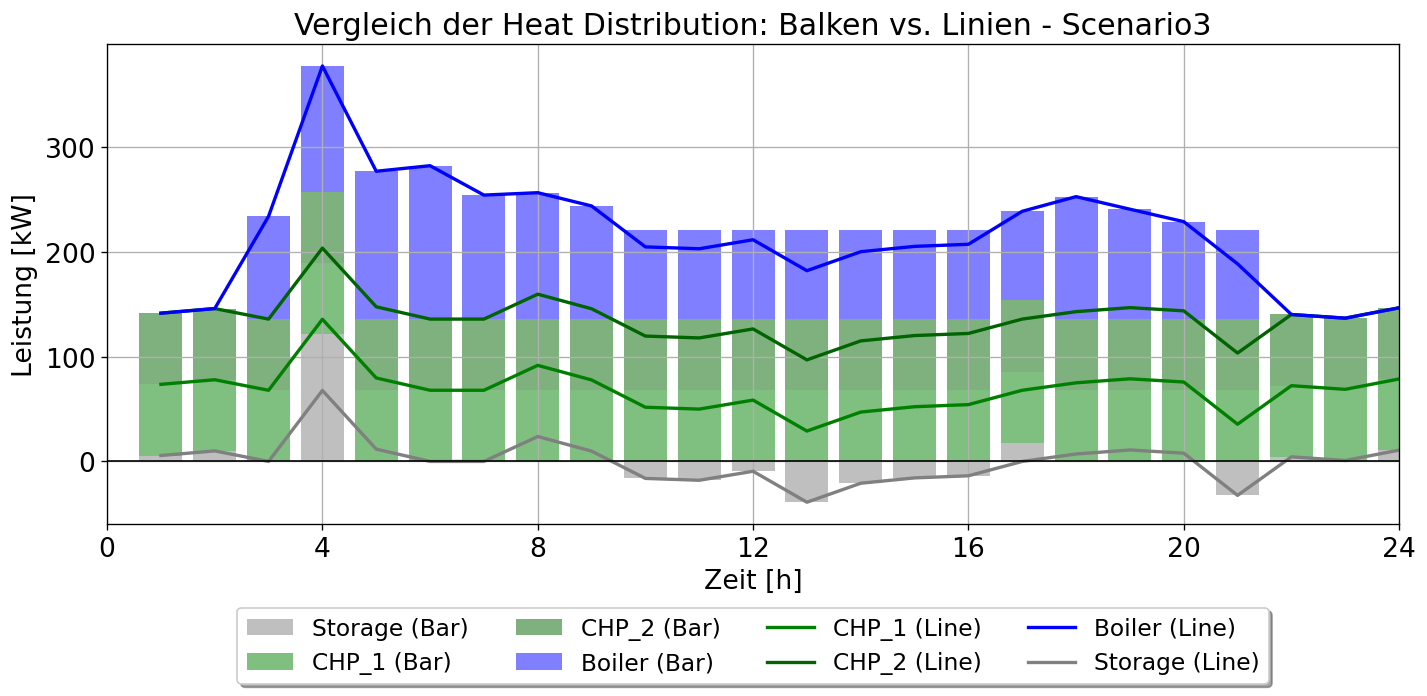

In [283]:
# Angenommen, deine DataFrames heißen df_deterministic_day und df_stochastic_day
scenario_to_plot = 'Scenario3'

plot_combined_visualization(
    df_bar=df_deterministic_day,
    df_line=df_stochastic_day,
    scenario_to_plot=scenario_to_plot,
    title='Vergleich der Heat Distribution: Balken vs. Linien',
    x_label='Zeit [h]',
    y_label='Leistung [kW]',
    xtick_step=4
)


---

# Visualisierung

## Allgemein

### Prices

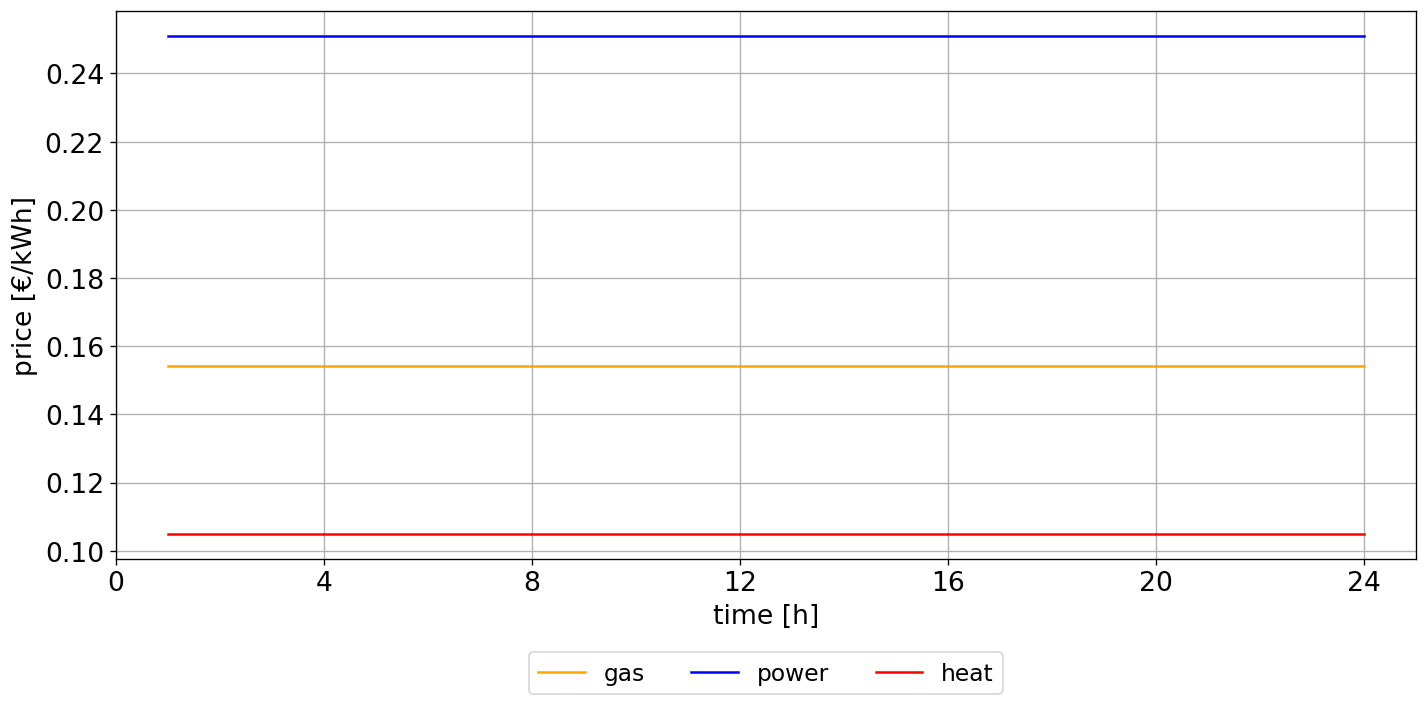

In [259]:
plot_prices(
    df_deterministic_day, 
    '',
    'time [h]',
    'price [€/kWh]',
    xtick_step=4
    )

# plot_prices(
#     df_deterministic_week, 
#     '',
#     'time [h]',
#     'price [€/kWh]',
#     xtick_step=24
#     )

### Heat Demand over time

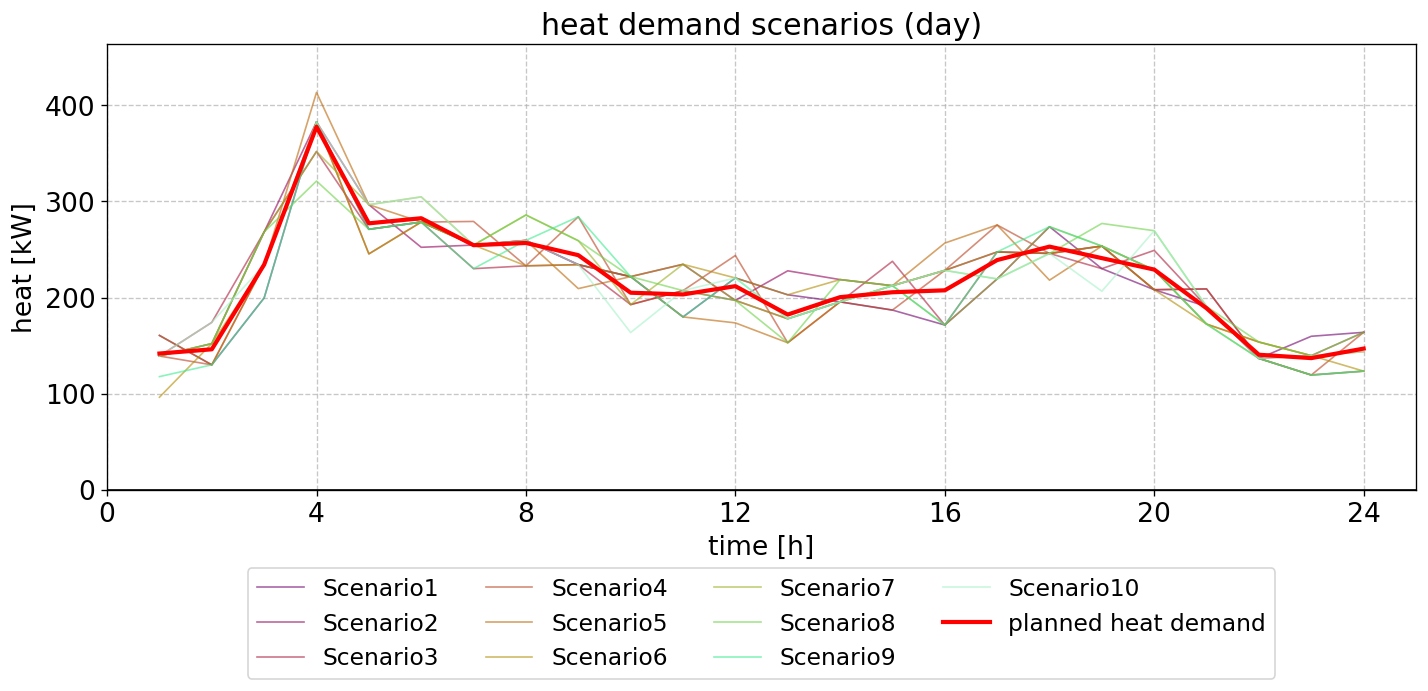

In [260]:
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']

# Heat Demand Szenarien für die Woche plotten
# plot_heat_demand_scenarios(
#     df_stochastic_week,
#     scenarios_to_plot,
#     'heat demand scenarios (week)',
#     'time [h]',
#     'heat [kW]',
#     xtick_step=24,
#     plot_planned_heat_demand=True
# )

# Heat Demand Szenarien für den Tag plotten
plot_heat_demand_scenarios(
    df_stochastic_day,
    scenarios_to_plot,
    'heat demand scenarios (day)',
    'time [h]',
    'heat [kW]',
    xtick_step=4
)

### Heat Demand over Time (Stochastic as a Band)

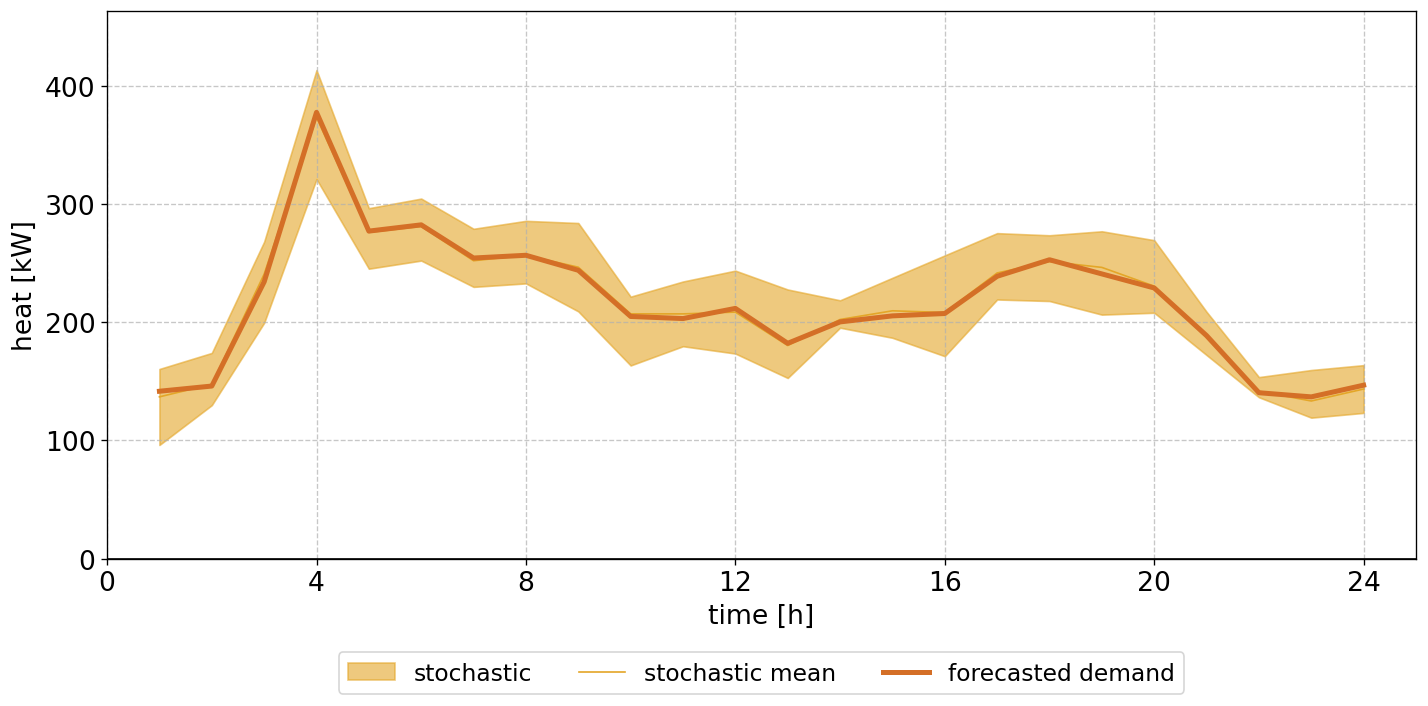

In [271]:
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']
plot_heat_demand_band(
    df_stochastic_day,
    scenarios_to_plot,
    '',
    'time [h]',
    'heat [kW]',
    xtick_step=4
)


---

## Deterministic Model

### Heat Distribution

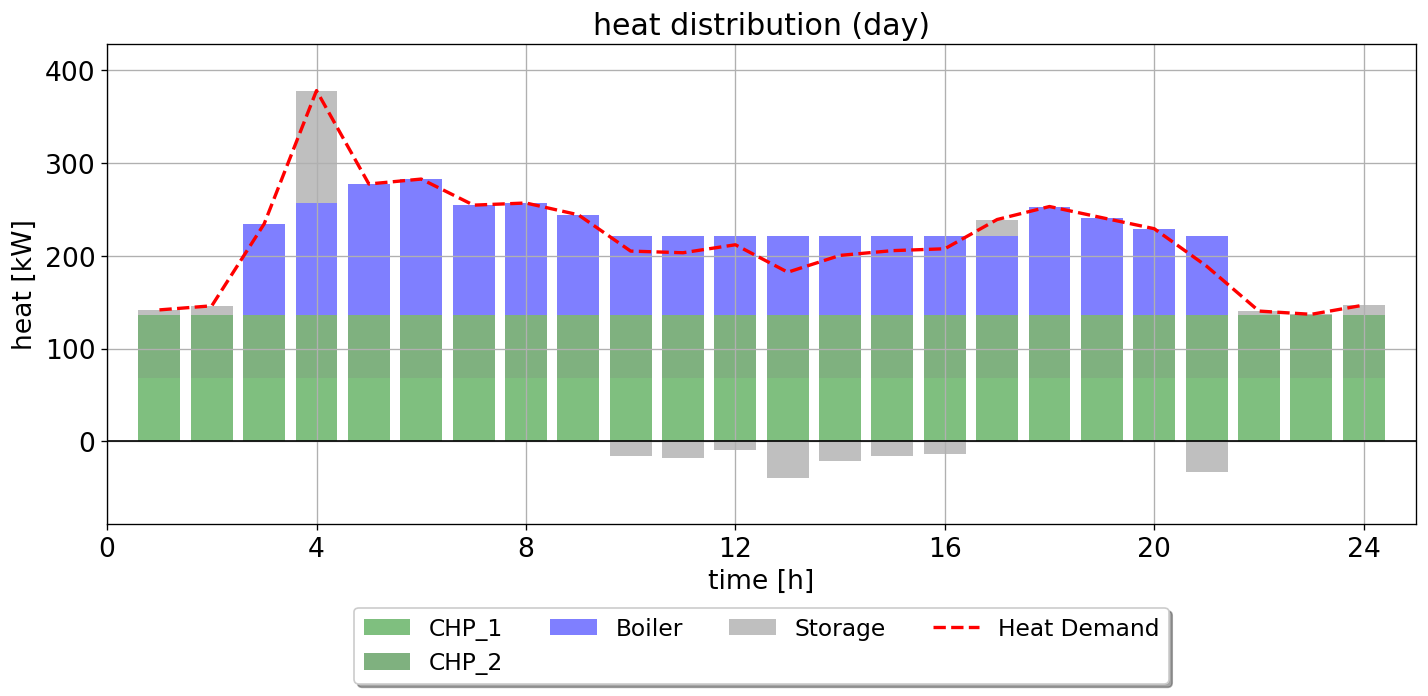

In [262]:
# Komponenten-Stacking-Plot für den Tag
plot_component_stacking(
    df_deterministic_day,
    'heat distribution (day)',
    'time [h]',
    'heat [kW]',
    xtick_step=4
)

### SOC

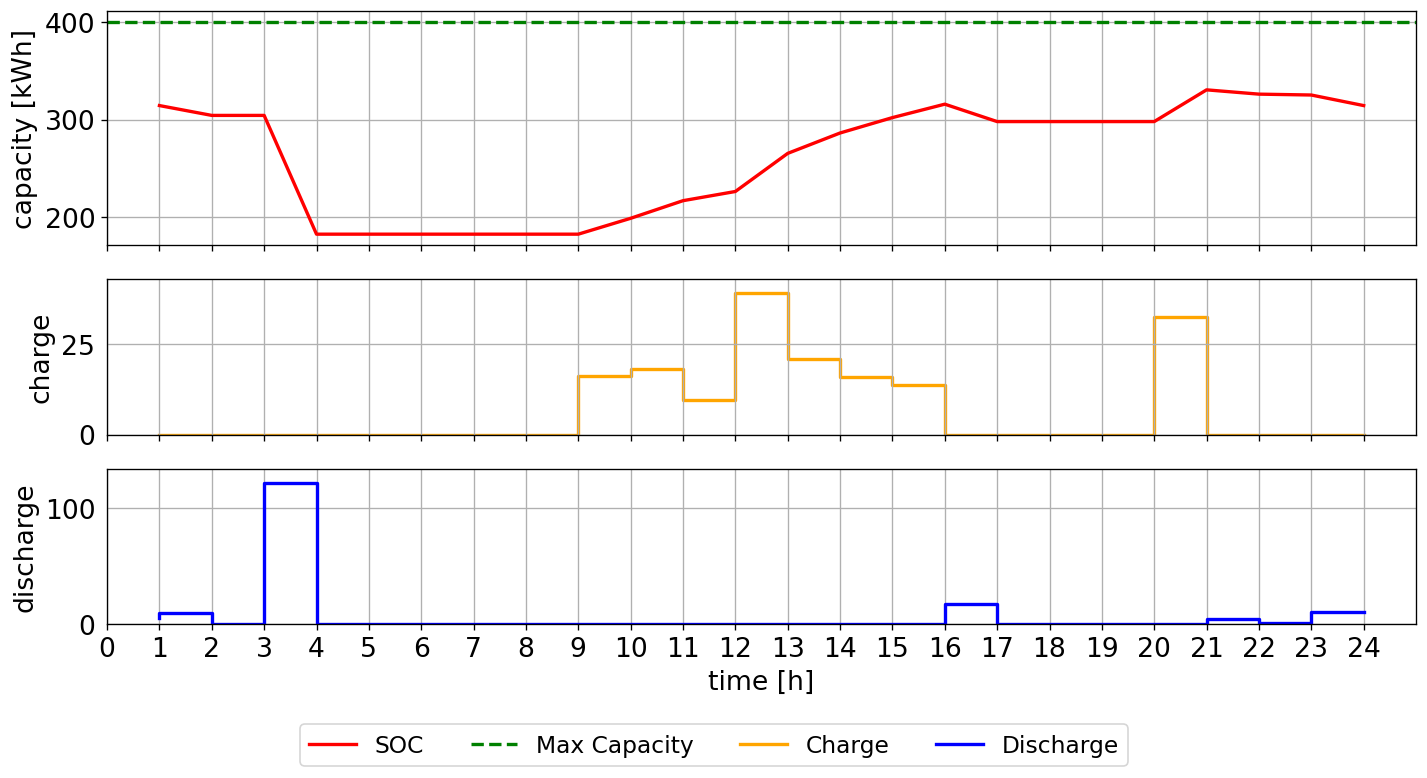

In [263]:
plot_stage_of_charge_deterministic(
        df=df_deterministic_day,
        title='',
        x_label='time [h]',
        y_label_soc='capacity [kWh]',
        y_label_discharge='discharge',
        y_label_charge='charge',
        xtick_step=1
    )

### Heat Distribution with Static Price

### Heat Distribution with Dynamic Price

### State of Charge

---

## Stochastic Model

### Commitment Decision: Stage 1

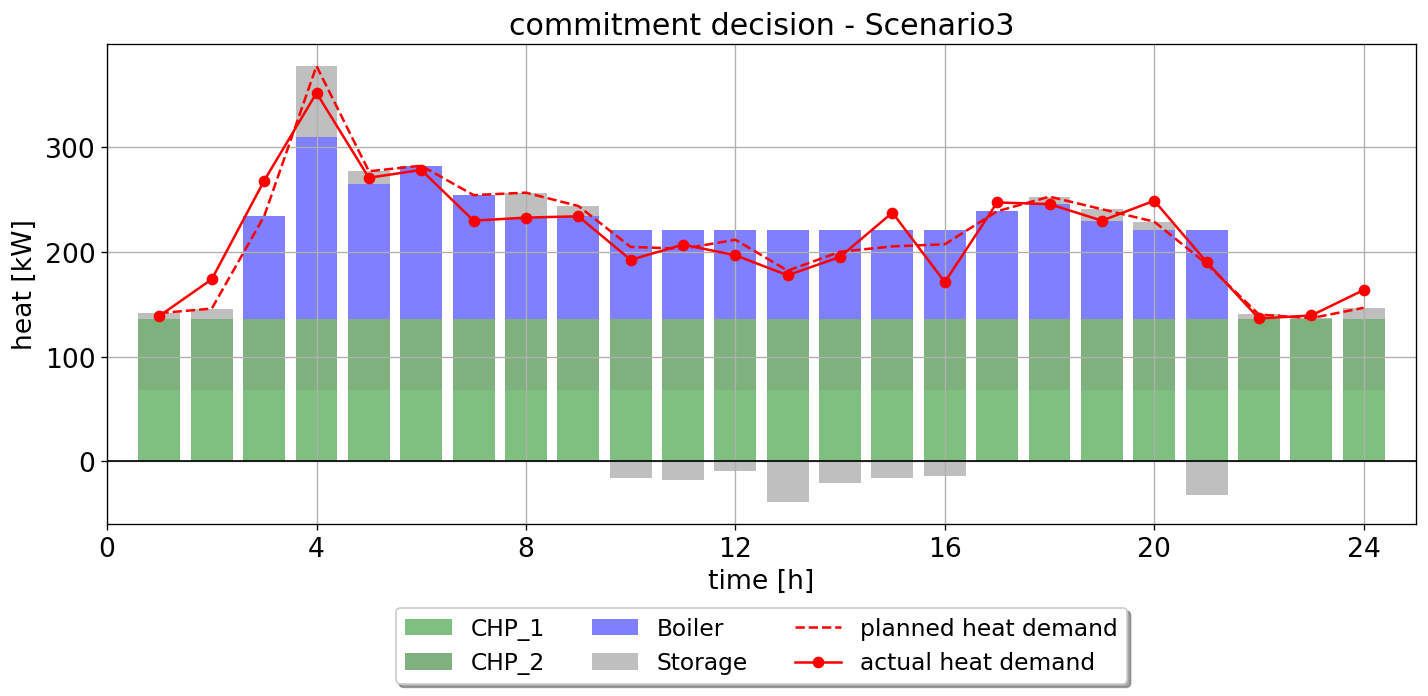

In [264]:
scenario_to_plot = 'Scenario3'

plot_commitment_decision(
    df_stochastic_day,
    scenario_to_plot,
    'commitment decision',
    'time [h]',
    'heat [kW]',
    xtick_step=4
)

### Dispatch

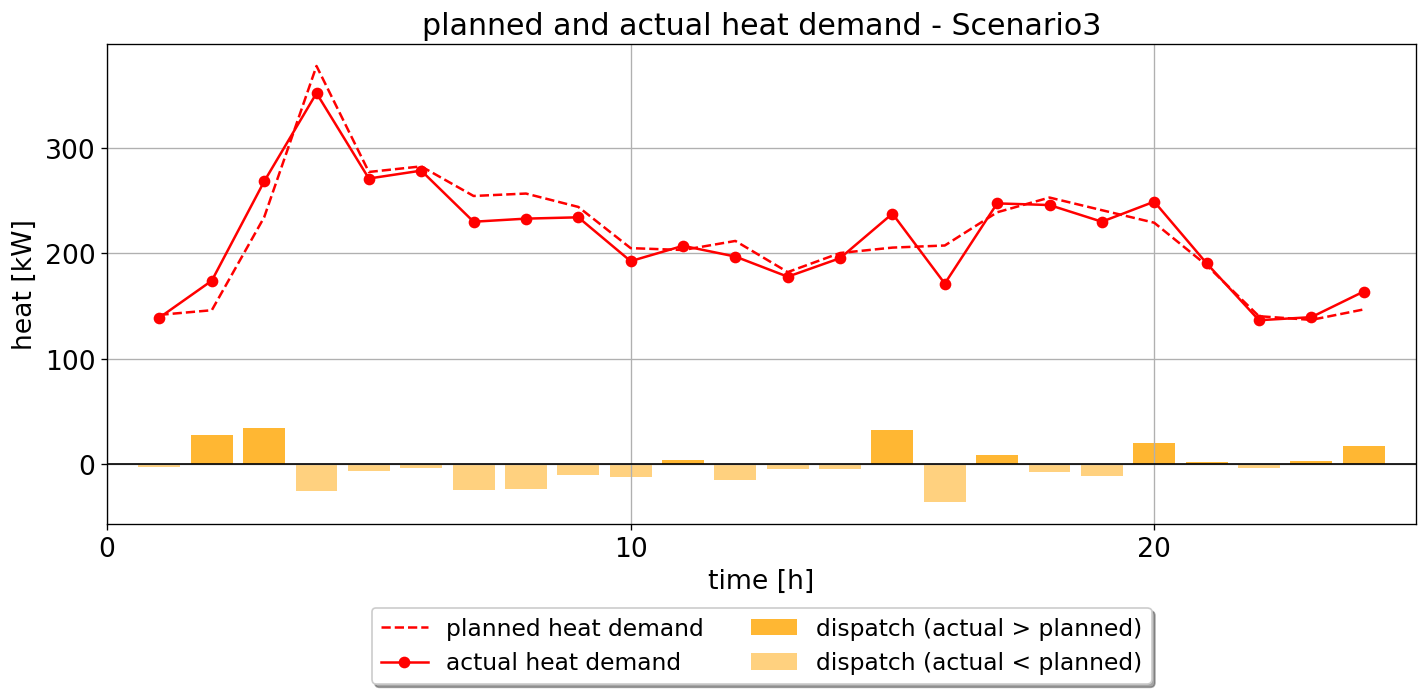

In [265]:
# Beispielhafte Nutzung der Funktion
scenario_to_plot = 'Scenario3'
plot_dispatch(
    df=df_stochastic_day,  # Dein stochastischer Tages-DataFrame
    scenario_to_plot=scenario_to_plot,  # Das Szenario, das du plotten möchtest
    title='planned and actual heat demand',
    x_label='time [h]',
    y_label='heat [kW]',
    xtick_step=10  # Beispiel: Schrittweite alle 4 Stunden
)

### Cumulative Dispatch

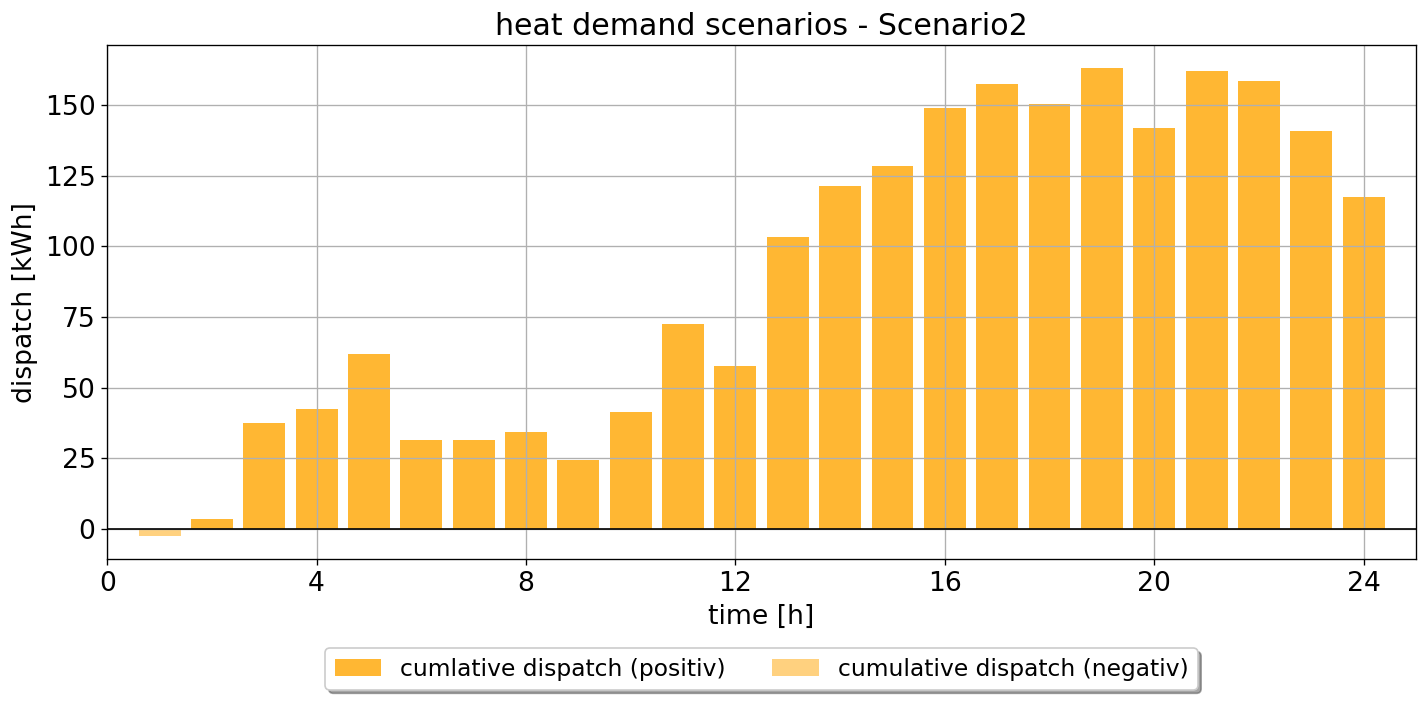

In [266]:
#scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']
scenarios_to_plot = ['Scenario2'] 

for scenario in scenarios_to_plot:
    plot_cumulative_dispatch(
        df=df_stochastic_day,
        scenario_to_plot=scenario,
        title='heat demand scenarios',
        x_label='time [h]',
        y_label='dispatch [kWh]',
        xtick_step=4  # Beispiel: jede Stunde
    )


### Dispatch Decision: Stage 2

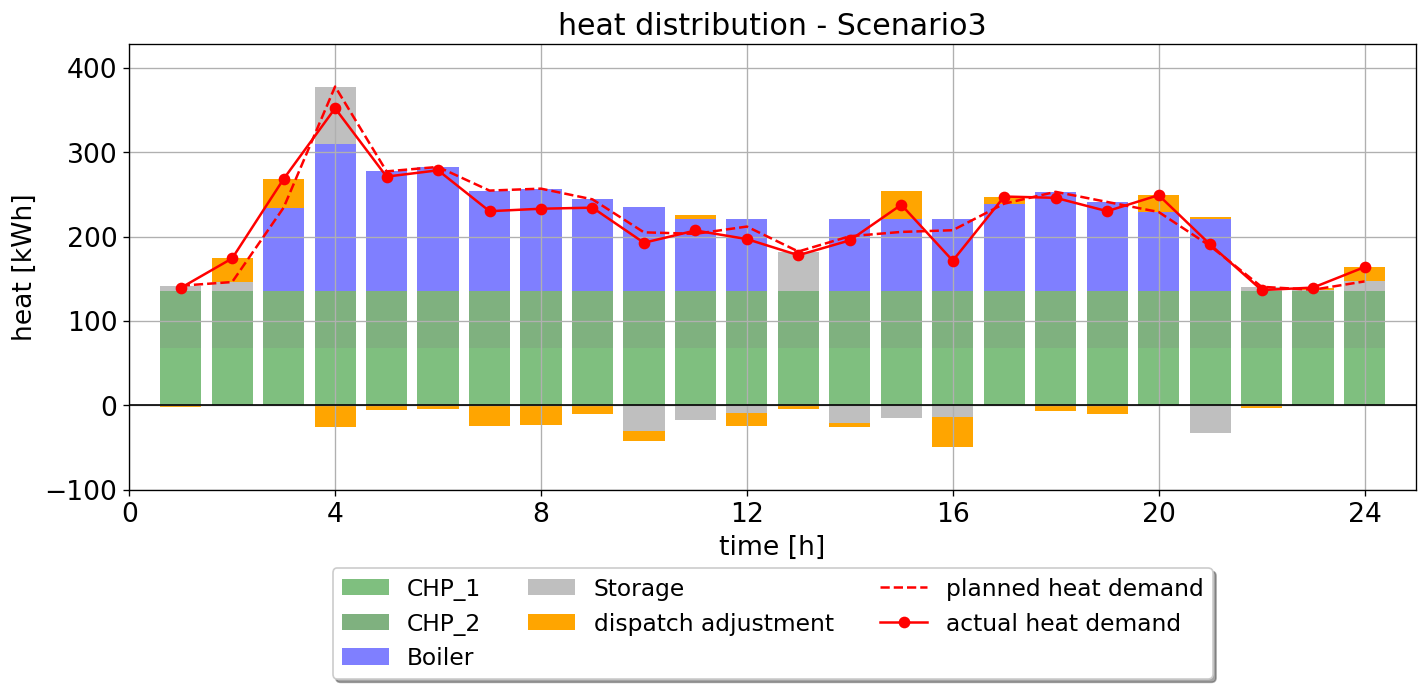

In [267]:
#scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']
scenarios_to_plot = ['Scenario3']
plot_component_stacking_stochastic(
    df_stochastic_day,
    scenarios_to_plot,
    'heat distribution',
    'time [h]',
    'heat [kWh]',
    xtick_step=4,
    soc_plot=False
)

# plot_component_stacking_stochastic(
#     df_stochastic_week,
#     scenarios_to_plot,
#     'Heat Distribution',
#     'time [h]',
#     'heat [kWh]',
#     xtick_step=24
# )

### State of Charge

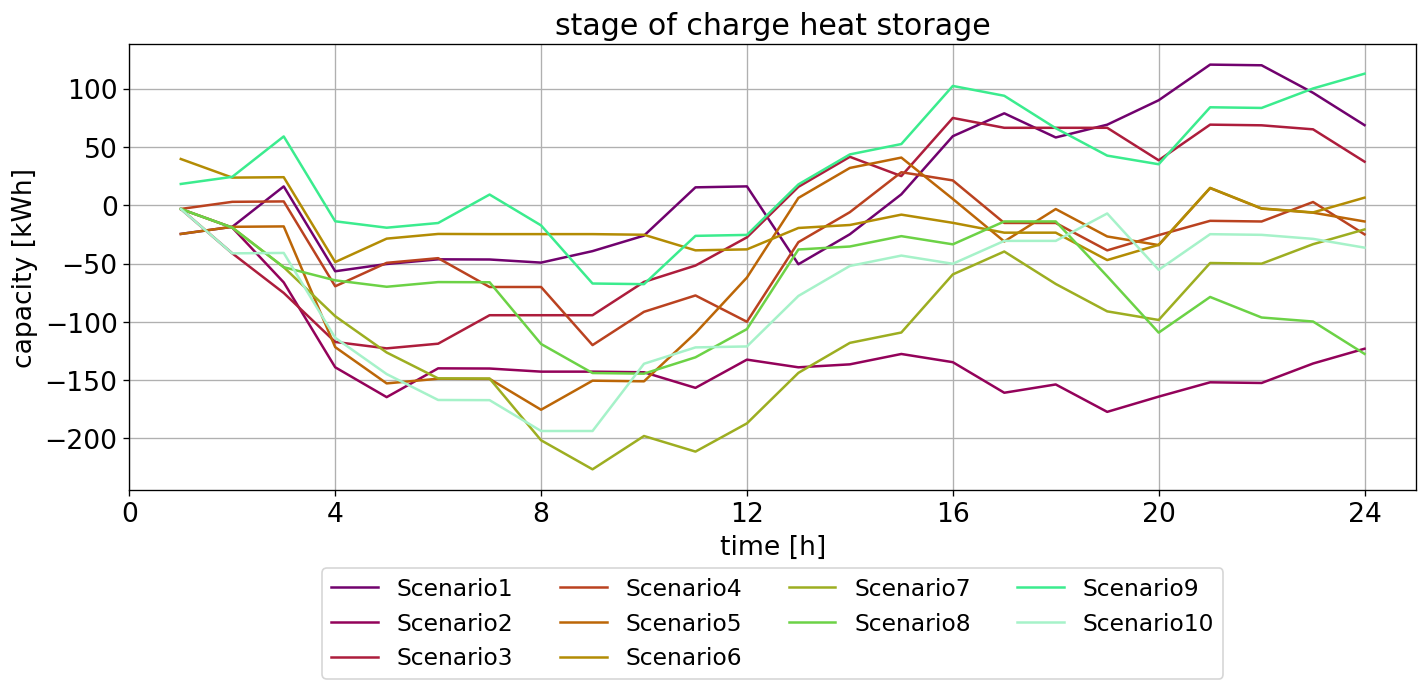

In [268]:
# Definiere die Liste der Szenarien
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']
plot_stage_of_charge(
    df=df_stochastic_day,
    scenarios_to_plot=scenarios_to_plot,
    title='stage of charge heat storage',
    x_label='time [h]',
    y_label='capacity [kWh]',
    xtick_step=4,  # Schrittweite für die x-Achse (z.B. jede Stunde)
)

# plot_stage_of_charge(
#     df=df_stochastic_week,
#     scenarios_to_plot=scenarios_to_plot,
#     title='stage of charge heat storage',
#     x_label='time [h]',
#     y_label='capacity [kWh]',
#     xtick_step=24,  # Schrittweite für die x-Achse (z.B. jede Stunde)
# )

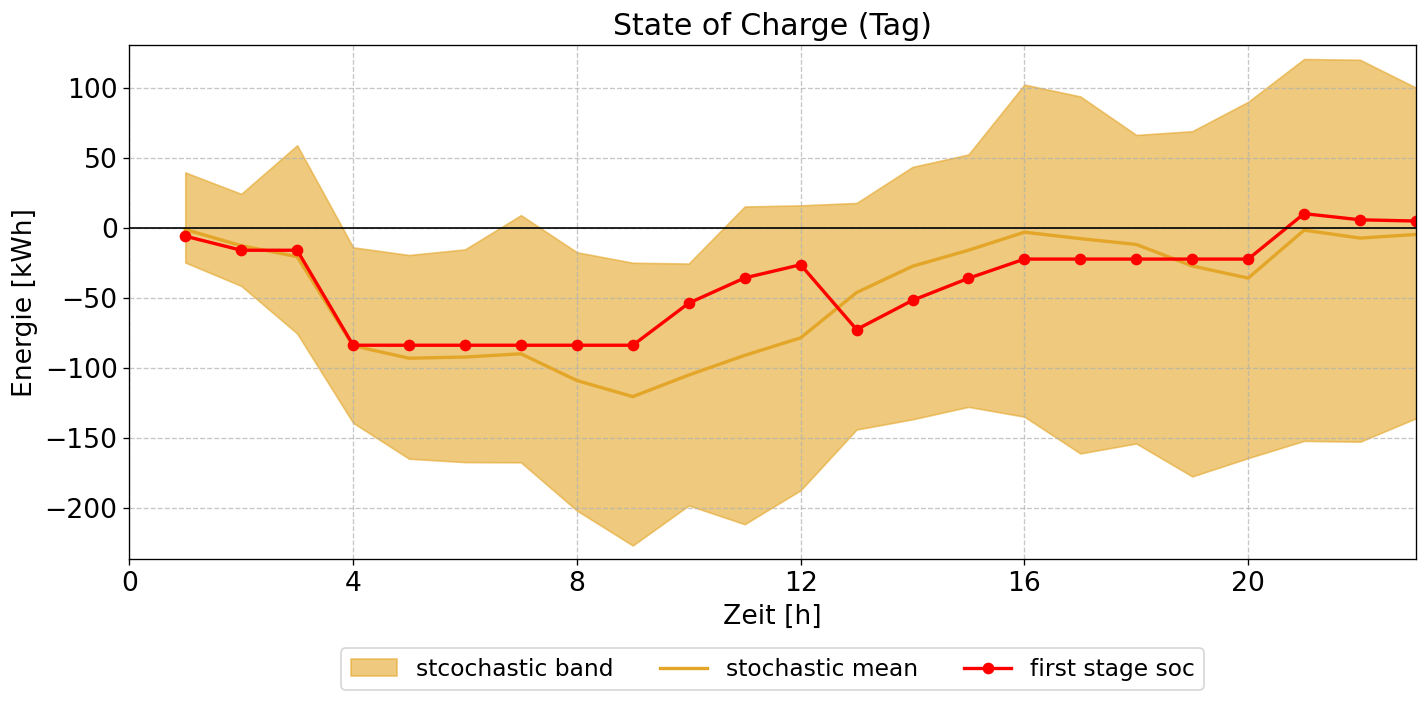

In [269]:
# Beispielaufruf der Funktion
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']

plot_state_of_charge_band(
    df_stochastic_day,
    scenarios_to_plot,
    'State of Charge (Tag)',
    'Zeit [h]',
    'Energie [kWh]',
    xtick_step=4
)